# Collect Number of Samples

In [9]:
# To see how many edges in each file
num_samples = []

for i in range(1, 11):
    edge_file = os.path.join(processed_data_path, f'conf{i}_edges.csv')
    edges = pd.read_csv(edge_file)
    num_samples.append(len(edges))

print('Number of samples (edges) in each configuration:', num_samples)

Number of samples (edges) in each configuration: [6068, 6245, 6054, 6157, 6464, 5972, 6502, 6294, 6053, 6376]


# GNN model

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
import torch_geometric.nn as pyg_nn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

In [29]:
class GranularDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        # Initialize scalers before super().__init__
        self.node_scaler = StandardScaler()
        self.edge_scaler = StandardScaler()
        self.target_scaler = StandardScaler()  # Fixed typo: StandardScaler instead of Standard StuartScaler
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_file_names(self):
        return [f"conf{i}_nodes.csv" for i in range(1, 11)] + [f"conf{i}_edges.csv" for i in range(1, 11)]

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        pass

    def process(self):
        data_list = []
        
        # Collect all data for normalization
        all_node_features = []
        all_edge_attrs = []
        all_targets = []
        
        for i in range(1, 11):
            nodes_path = os.path.join(self.raw_dir, f"conf{i}_nodes.csv")
            edges_path = os.path.join(self.raw_dir, f"conf{i}_edges.csv")

            try:
                nodes_df = pd.read_csv(nodes_path)
                edges_df = pd.read_csv(edges_path)

                # Validate edges
                valid_nodes = set(nodes_df['id'])
                original_edge_count = len(edges_df)
                edges_df = edges_df[edges_df['id1'].isin(valid_nodes) & edges_df['id2'].isin(valid_nodes)]
                filtered_edge_count = len(edges_df)
                if filtered_edge_count < original_edge_count:
                    logging.warning(f"Conf{i}: Filtered {original_edge_count - filtered_edge_count} invalid edges")

                # Collect features
                node_features = nodes_df[['type', 'diameter', 'x', 'y', 'disp_x', 'disp_y', 'vel_x', 'vel_y', 'num_contacts', 'ang_vel_z']].values
                edge_attr = edges_df[['distance', 'tangential_force_x', 'tangential_force_y', 'rel_vel_x', 'rel_vel_y']].values
                edge_labels = edges_df['total_normal_force'].values.reshape(-1, 1)

                all_node_features.append(node_features)
                all_edge_attrs.append(edge_attr)
                all_targets.append(edge_labels)
            except FileNotFoundError:
                logging.error(f"File missing for conf{i}: {nodes_path} or {edges_path}")
                raise
            except pd.errors.EmptyDataError:
                logging.error(f"Empty or malformed file for conf{i}: {nodes_path} or {edges_path}")
                raise

        # Fit scalers
        try:
            all_node_features = np.vstack(all_node_features)
            all_edge_attrs = np.vstack(all_edge_attrs)
            all_targets = np.vstack(all_targets)
            
            self.node_scaler.fit(all_node_features)
            self.edge_scaler.fit(all_edge_attrs)
            self.target_scaler.fit(all_targets)
        except ValueError as e:
            logging.error(f"Error fitting scalers: {e}")
            raise

        # Process each configuration
        for i in range(1, 11):
            nodes_path = os.path.join(self.raw_dir, f"conf{i}_nodes.csv")
            edges_path = os.path.join(self.raw_dir, f"conf{i}_edges.csv")

            try:
                nodes_df = pd.read_csv(nodes_path)
                edges_df = pd.read_csv(edges_path)

                # Validate edges
                valid_nodes = set(nodes_df['id'])
                original_edge_count = len(edges_df)
                edges_df = edges_df[edges_df['id1'].isin(valid_nodes) & edges_df['id2'].isin(valid_nodes)]
                filtered_edge_count = len(edges_df)
                if filtered_edge_count < original_edge_count:
                    logging.warning(f"Conf{i}: Filtered {original_edge_count - filtered_edge_count} invalid edges")

                # Build node ID mapping
                id_mapping = {id_: idx for idx, id_ in enumerate(nodes_df['id'].values)}

                # Build node features and normalize
                node_features = nodes_df[['type', 'diameter', 'x', 'y', 'disp_x', 'disp_y', 'vel_x', 'vel_y', 'num_contacts', 'ang_vel_z']].values
                node_features = self.node_scaler.transform(node_features)
                node_features = torch.tensor(node_features, dtype=torch.float)

                # Build edge index
                mapped_edges = edges_df[['id1', 'id2']].apply(lambda col: col.map(id_mapping)).values
                edge_index = torch.tensor(mapped_edges.T, dtype=torch.long)

                # Build edge attributes and normalize
                edge_attr = edges_df[['distance', 'tangential_force_x', 'tangential_force_y', 'rel_vel_x', 'rel_vel_y']].values
                edge_attr = self.edge_scaler.transform(edge_attr)
                edge_attr = torch.tensor(edge_attr, dtype=torch.float)

                # Target and normalize
                edge_labels = edges_df['total_normal_force'].values.reshape(-1, 1)
                edge_labels = self.target_scaler.transform(edge_labels).ravel()
                edge_labels = torch.tensor(edge_labels, dtype=torch.float)

                data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=edge_labels)
                data_list.append(data)
            except FileNotFoundError:
                logging.error(f"File missing for conf{i}: {nodes_path} or {edges_path}")
                raise
            except pd.errors.EmptyDataError:
                logging.error(f"Empty or malformed file for conf{i}: {nodes_path} or {edges_path}")
                raise

        try:
            data, slices = self.collate(data_list)
            torch.save((data, slices), self.processed_paths[0])
        except Exception as e:
            logging.error(f"Error saving processed data: {e}")
            raise

In [30]:
try:
    dataset = GranularDataset(root=processed_data_path)

    # Split: conf1-5 train, conf6 validation, conf7-10 test
    train_dataset = dataset[:5]
    val_dataset = dataset[5:6]
    test_dataset = dataset[6:]

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    print(f"Train graphs: {len(train_dataset)}, Val graphs: {len(val_dataset)}, Test graphs: {len(test_dataset)}")
except Exception as e:
    logging.error(f"Error creating dataset or dataloaders: {e}")
    raise

Processing...


Train graphs: 5, Val graphs: 1, Test graphs: 4


Done!


In [31]:
class GNNModel(nn.Module):
    def __init__(self, node_input_dim, edge_input_dim, hidden_dim):
        super(GNNModel, self).__init__()
        self.conv1 = pyg_nn.GCNConv(node_input_dim, hidden_dim)
        self.conv2 = pyg_nn.GCNConv(hidden_dim, hidden_dim)
        self.conv3 = pyg_nn.GCNConv(hidden_dim, hidden_dim)

        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim + edge_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()

        row, col = edge_index
        edge_inputs = torch.cat([x[row], x[col], edge_attr], dim=1)

        out = self.edge_mlp(edge_inputs).squeeze()
        return out

In [32]:
node_input_dim = 10  # type, diameter, x, y, disp_x, disp_y, vel_x, vel_y, num_contacts, ang_vel_z
edge_input_dim = 5   # distance, tangential_force_x, tangential_force_y, rel_vel_x, rel_vel_y
hidden_dim = 256     # Increased for better capacity

try:
    model = GNNModel(node_input_dim=node_input_dim, edge_input_dim=edge_input_dim, hidden_dim=hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)  # Removed verbose=True
    criterion = nn.MSELoss()
except Exception as e:
    logging.error(f"Error initializing model or optimizer: {e}")
    raise

In [33]:
def train(model, loader, val_loader, criterion, optimizer, scheduler, target_scaler):
    model.train()
    total_loss = 0
    for data in loader:
        try:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        except Exception as e:
            logging.error(f"Error during training step: {e}")
            raise
    avg_train_loss = total_loss / len(loader)
    
    # Validation
    try:
        val_loss, _, _ = evaluate(model, val_loader, criterion, target_scaler)
        scheduler.step(val_loss)
    except Exception as e:
        logging.error(f"Error during validation: {e}")
        raise
    
    return avg_train_loss, val_loss

def evaluate(model, loader, criterion, target_scaler):
    model.eval()
    total_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for data in loader:
            try:
                data = data.to(device)
                out = model(data)
                loss = criterion(out, data.y)
                total_loss += loss.item()
                
                # Denormalize for metrics
                pred_denorm = target_scaler.inverse_transform(out.cpu().numpy().reshape(-1, 1)).ravel()
                target_denorm = target_scaler.inverse_transform(data.y.cpu().numpy().reshape(-1, 1)).ravel()
                
                preds.append(pred_denorm)
                targets.append(target_denorm)
            except Exception as e:
                logging.error(f"Error during evaluation step: {e}")
                raise
    
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    avg_loss = total_loss / len(loader)
    return avg_loss, preds, targets

def get_metrics(preds, targets):
    try:
        l1 = mean_absolute_error(targets, preds)
        l2 = np.sqrt(mean_squared_error(targets, preds))
        mse = mean_squared_error(targets, preds)
        r2 = r2_score(targets, preds)
        pearson_corr, _ = pearsonr(targets, preds)
        return {'L1': l1, 'L2': l2, 'MSE': mse, 'R2': r2, 'Pearson': pearson_corr}
    except Exception as e:
        logging.error(f"Error computing metrics: {e}")
        raise

# Results

In [34]:
num_epochs = 250  # Maximum epochs
patience = 50     # Early stopping patience
best_val_loss = float('inf')
best_model_path = os.path.join(processed_data_path, 'best_model.pt')
counter = 0
train_losses = []
val_losses = []

try:
    for epoch in range(num_epochs):
        train_loss, val_loss = train(model, train_loader, val_loader, criterion, optimizer, scheduler, dataset.target_scaler)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        
        # Early stopping and model checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    # Load best model
    model.load_state_dict(torch.load(best_model_path, weights_only=True))
except Exception as e:
    logging.error(f"Error during training loop: {e}")
    raise

Epoch 0 | Train Loss: 0.8010 | Val Loss: 0.4048
Epoch 10 | Train Loss: 0.0461 | Val Loss: 0.0305
Epoch 20 | Train Loss: 0.0115 | Val Loss: 0.0018
Epoch 30 | Train Loss: 0.0062 | Val Loss: 0.0008
Epoch 40 | Train Loss: 0.0064 | Val Loss: 0.0021
Epoch 50 | Train Loss: 0.0038 | Val Loss: 0.0004
Epoch 60 | Train Loss: 0.0031 | Val Loss: 0.0002
Epoch 70 | Train Loss: 0.0030 | Val Loss: 0.0001
Epoch 80 | Train Loss: 0.0028 | Val Loss: 0.0002
Epoch 90 | Train Loss: 0.0025 | Val Loss: 0.0001
Epoch 100 | Train Loss: 0.0024 | Val Loss: 0.0002
Epoch 110 | Train Loss: 0.0023 | Val Loss: 0.0000
Epoch 120 | Train Loss: 0.0021 | Val Loss: 0.0000
Epoch 130 | Train Loss: 0.0021 | Val Loss: 0.0000
Epoch 140 | Train Loss: 0.0021 | Val Loss: 0.0000
Epoch 150 | Train Loss: 0.0019 | Val Loss: 0.0000
Epoch 160 | Train Loss: 0.0020 | Val Loss: 0.0000
Epoch 170 | Train Loss: 0.0020 | Val Loss: 0.0000
Epoch 180 | Train Loss: 0.0019 | Val Loss: 0.0000
Epoch 190 | Train Loss: 0.0020 | Val Loss: 0.0000
Epoch 200 |


Train Metrics: {'L1': 1.349599, 'L2': 1.7624816, 'MSE': 3.1063414, 'R2': 0.9999790282688872, 'Pearson': 0.9999897258112725}
Validation Metrics: {'L1': 1.5005449, 'L2': 1.9418949, 'MSE': 3.7709556, 'R2': 0.9999046697315994, 'Pearson': 0.9999532263050694}
Test Metrics: {'L1': 1.6077521, 'L2': 2.4920688, 'MSE': 6.2104063, 'R2': 0.9999746477135163, 'Pearson': 0.9999873445787801}


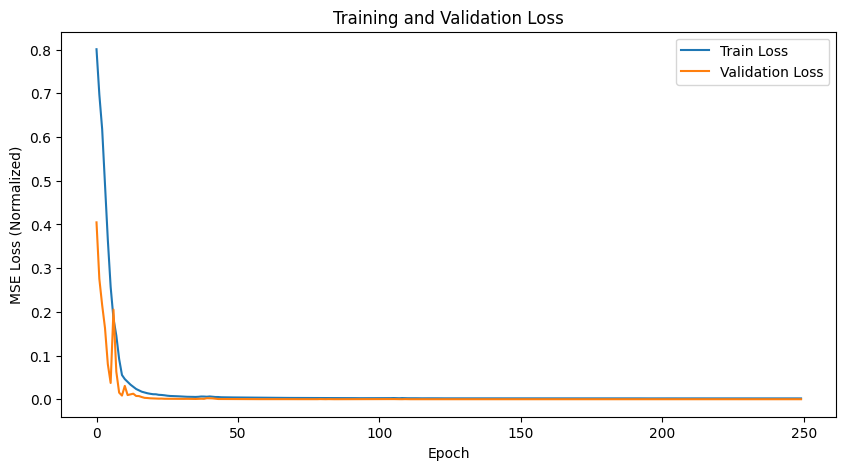

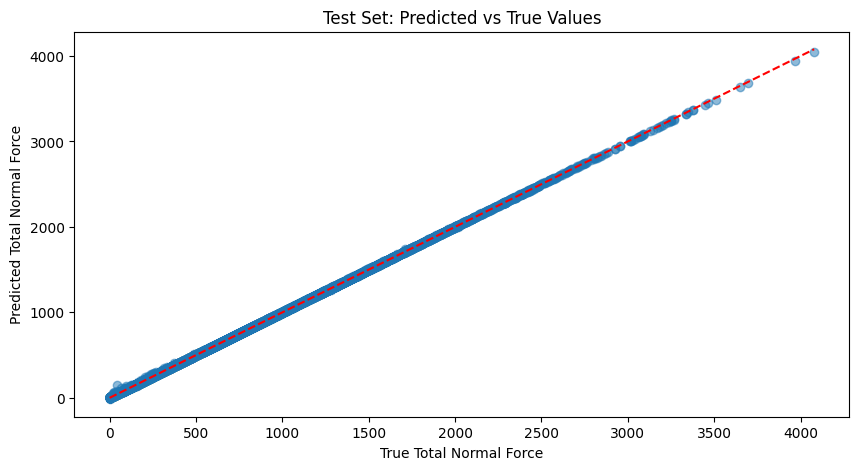

In [35]:
try:
    # Evaluate on train, validation, and test sets
    train_loss, train_preds, train_targets = evaluate(model, train_loader, criterion, dataset.target_scaler)
    val_loss, val_preds, val_targets = evaluate(model, val_loader, criterion, dataset.target_scaler)
    test_loss, test_preds, test_targets = evaluate(model, test_loader, criterion, dataset.target_scaler)

    train_metrics = get_metrics(train_preds, train_targets)
    val_metrics = get_metrics(val_preds, val_targets)
    test_metrics = get_metrics(test_preds, test_targets)

    print("\nTrain Metrics:", train_metrics)
    print("Validation Metrics:", val_metrics)
    print("Test Metrics:", test_metrics)

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss (Normalized)')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig(os.path.join(processed_data_path, 'loss_curve.png'))
    plt.show()

    # Plot predictions vs targets for test set
    plt.figure(figsize=(10, 5))
    plt.scatter(test_targets, test_preds, alpha=0.5)
    plt.plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'r--')
    plt.xlabel('True Total Normal Force')
    plt.ylabel('Predicted Total Normal Force')
    plt.title('Test Set: Predicted vs True Values')
    plt.savefig(os.path.join(processed_data_path, 'pred_vs_true.png'))
    plt.show()
except Exception as e:
    logging.error(f"Error during evaluation or visualization: {e}")
    raise

2025-05-12 20:59:22,343 - INFO - Saved plot for conf1 at C:\Users\UIET\Desktop\Ananya\IIT\Sem 6\BTP\post midsem data\Data_processed2\conf1_pred_vs_actual.png


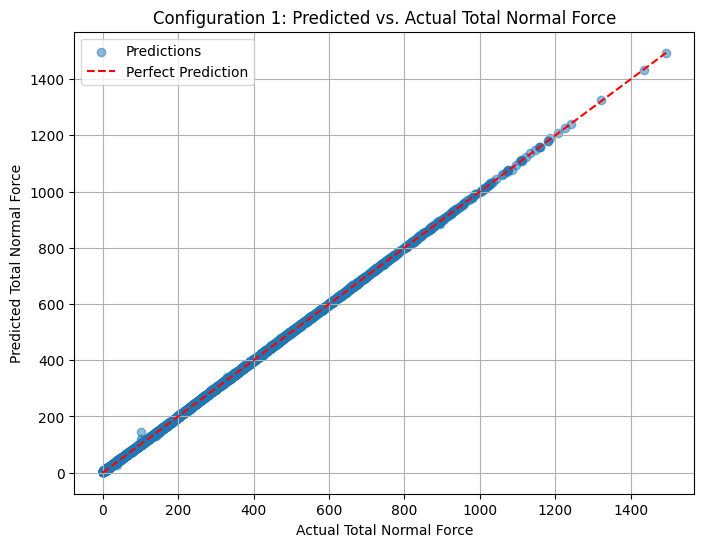

2025-05-12 20:59:23,095 - INFO - Saved plot for conf2 at C:\Users\UIET\Desktop\Ananya\IIT\Sem 6\BTP\post midsem data\Data_processed2\conf2_pred_vs_actual.png


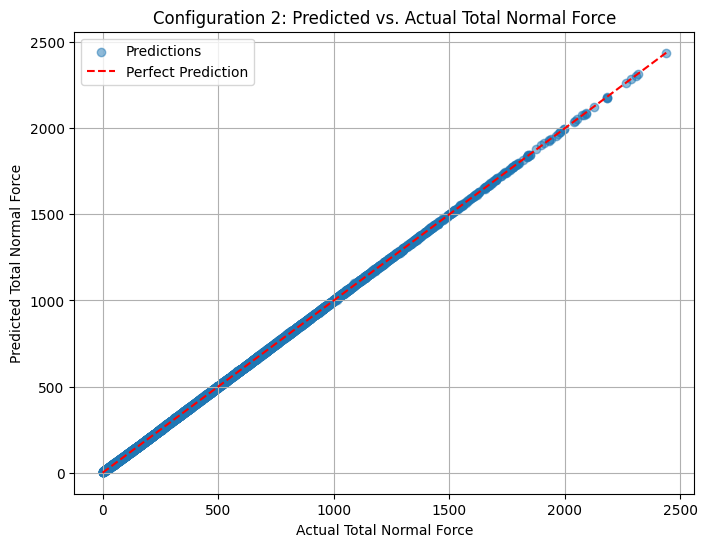

2025-05-12 20:59:23,749 - INFO - Saved plot for conf3 at C:\Users\UIET\Desktop\Ananya\IIT\Sem 6\BTP\post midsem data\Data_processed2\conf3_pred_vs_actual.png


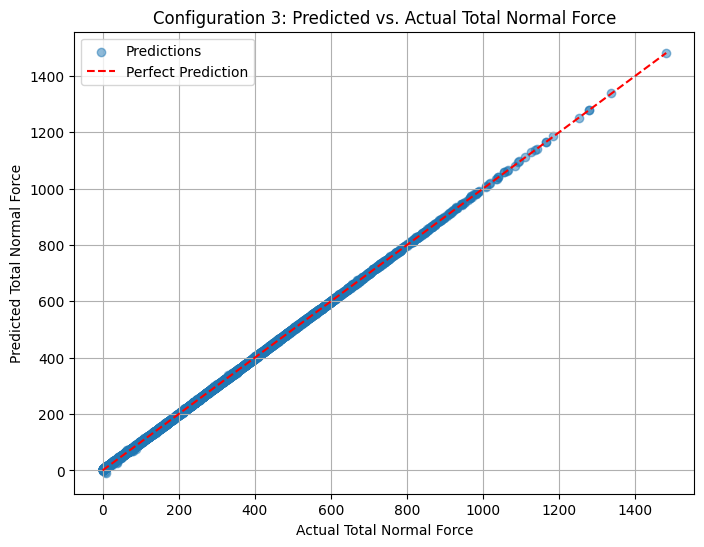

2025-05-12 20:59:24,388 - INFO - Saved plot for conf4 at C:\Users\UIET\Desktop\Ananya\IIT\Sem 6\BTP\post midsem data\Data_processed2\conf4_pred_vs_actual.png


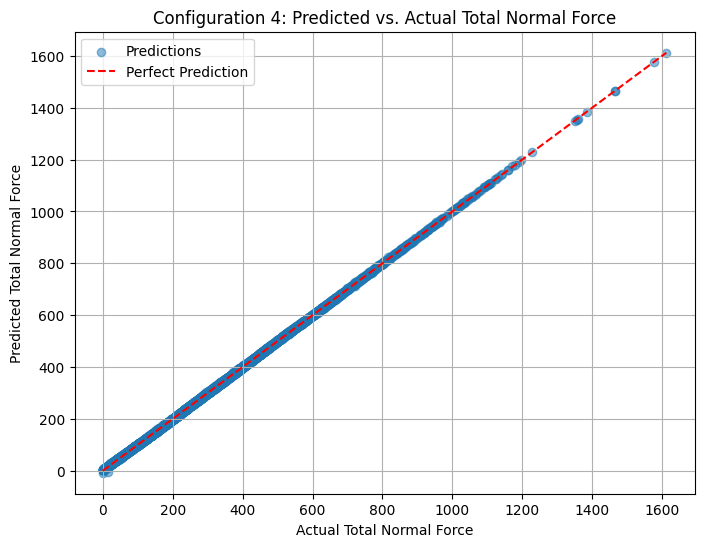

2025-05-12 20:59:24,973 - INFO - Saved plot for conf5 at C:\Users\UIET\Desktop\Ananya\IIT\Sem 6\BTP\post midsem data\Data_processed2\conf5_pred_vs_actual.png


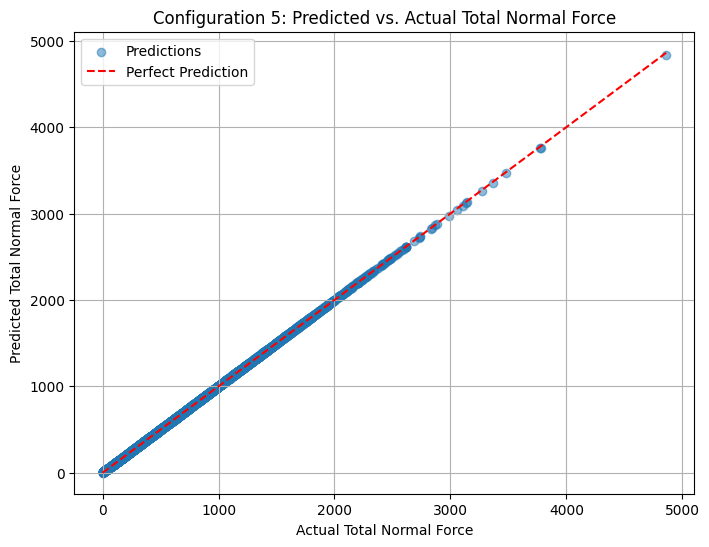

2025-05-12 20:59:25,567 - INFO - Saved plot for conf6 at C:\Users\UIET\Desktop\Ananya\IIT\Sem 6\BTP\post midsem data\Data_processed2\conf6_pred_vs_actual.png


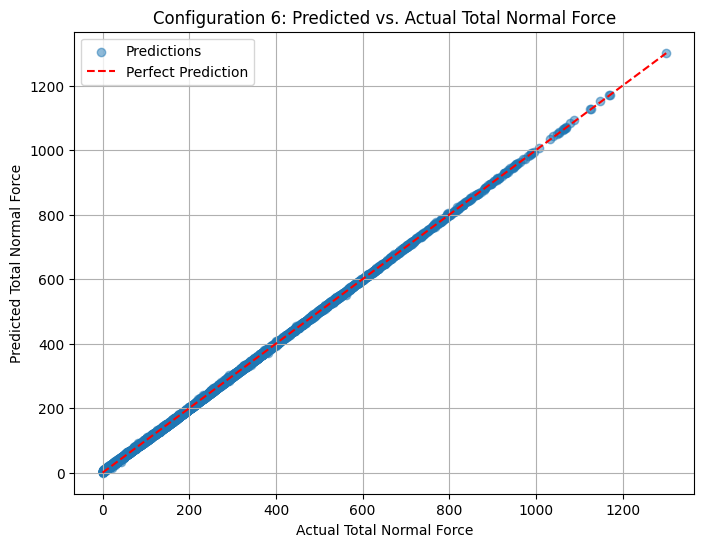

2025-05-12 20:59:26,175 - INFO - Saved plot for conf7 at C:\Users\UIET\Desktop\Ananya\IIT\Sem 6\BTP\post midsem data\Data_processed2\conf7_pred_vs_actual.png


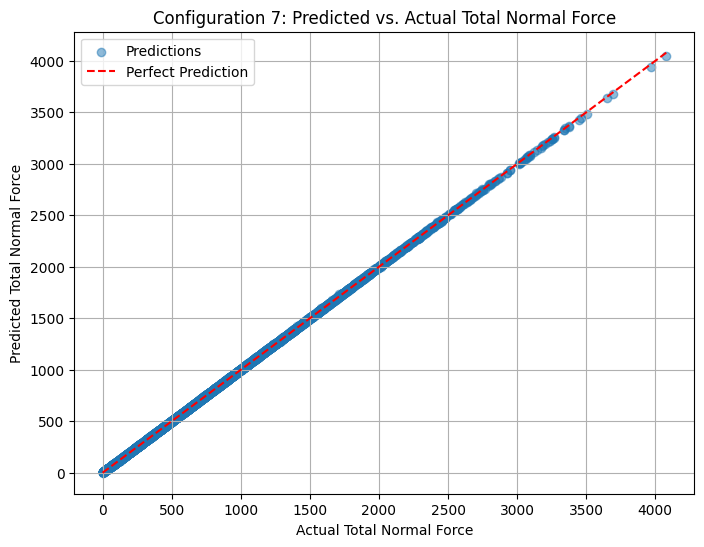

2025-05-12 20:59:26,829 - INFO - Saved plot for conf8 at C:\Users\UIET\Desktop\Ananya\IIT\Sem 6\BTP\post midsem data\Data_processed2\conf8_pred_vs_actual.png


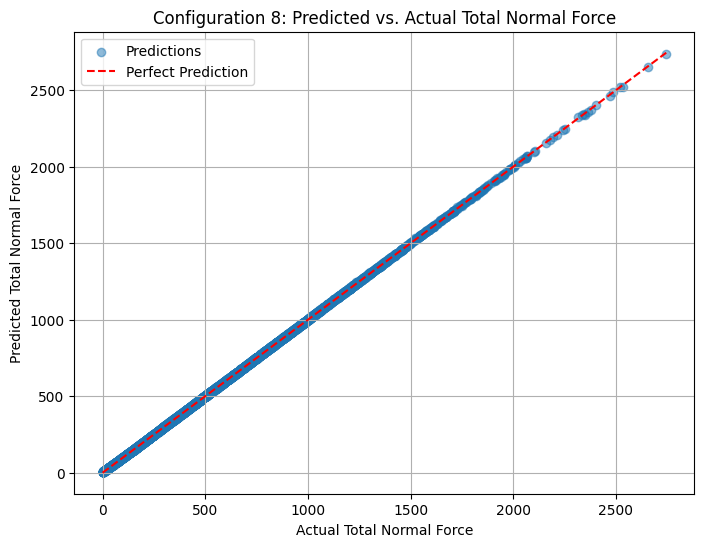

2025-05-12 20:59:27,516 - INFO - Saved plot for conf9 at C:\Users\UIET\Desktop\Ananya\IIT\Sem 6\BTP\post midsem data\Data_processed2\conf9_pred_vs_actual.png


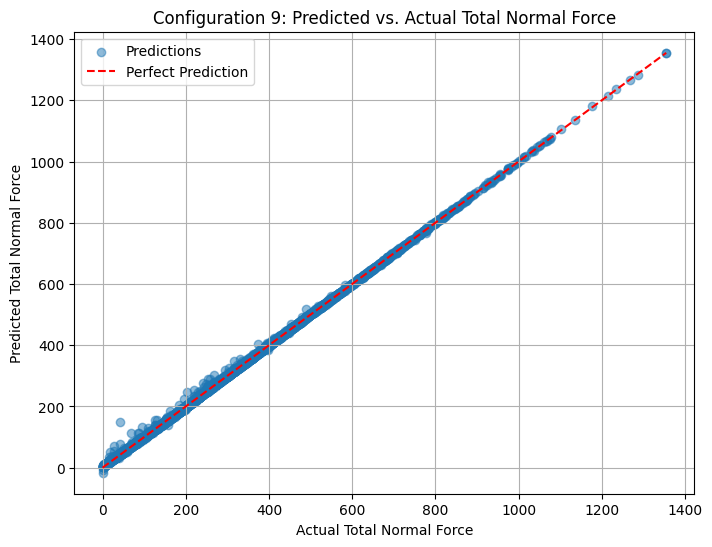

2025-05-12 20:59:28,159 - INFO - Saved plot for conf10 at C:\Users\UIET\Desktop\Ananya\IIT\Sem 6\BTP\post midsem data\Data_processed2\conf10_pred_vs_actual.png


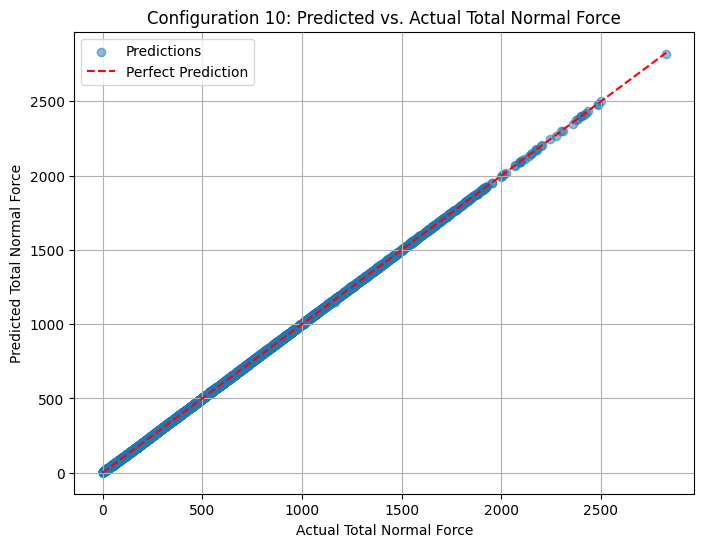

In [36]:
from torch_geometric.loader import DataLoader

# Ensure logging is set up (from Cell 1)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def plot_pred_vs_actual_per_config(dataset, model, processed_data_path, device, target_scaler):
    """
    Generate scatter plots of predicted vs. actual total_normal_force for each configuration.
    
    Args:
        dataset: GranularDataset containing all configurations.
        model: Trained GNNModel.
        processed_data_path: Directory to save_save plots.
        device: Device (cuda or cpu) for model evaluation.
        target_scaler: StandardScaler for denormalizing predictions and targets.
    """
    model.eval()
    loader = DataLoader(dataset[:], batch_size=1, shuffle=False)  # Load all configurations
    
    for i, data in enumerate(loader, 1):  # Configurations are 1-indexed (conf1 to conf10)
        try:
            data = data.to(device)
            with torch.no_grad():
                preds = model(data)
            
            # Denormalize predictions and targets
            preds_denorm = target_scaler.inverse_transform(preds.cpu().numpy().reshape(-1, 1)).ravel()
            targets_denorm = target_scaler.inverse_transform(data.y.cpu().numpy().reshape(-1, 1)).ravel()
            
            # Create scatter plot
            plt.figure(figsize=(8, 6))
            plt.scatter(targets_denorm, preds_denorm, alpha=0.5, label='Predictions')
            plt.plot([targets_denorm.min(), targets_denorm.max()], 
                     [targets_denorm.min(), targets_denorm.max()], 
                     'r--', label='Perfect Prediction')
            plt.xlabel('Actual Total Normal Force')
            plt.ylabel('Predicted Total Normal Force')
            plt.title(f'Configuration {i}: Predicted vs. Actual Total Normal Force')
            plt.legend()
            plt.grid(True)
            
            # Save plot
            plot_path = os.path.join(processed_data_path, f'conf{i}_pred_vs_actual.png')
            plt.savefig(plot_path)
            logging.info(f"Saved plot for conf{i} at {plot_path}")
            plt.show()
            plt.close()
            
        except Exception as e:
            logging.error(f"Error plotting for conf{i}: {e}")
            raise

# Run the plotting function
try:
    plot_pred_vs_actual_per_config(dataset, model, processed_data_path, device, dataset.target_scaler)
except Exception as e:
    logging.error(f"Error in per-configuration plotting: {e}")
    raise

2025-05-12 20:32:02,481 - INFO - Saved plot for conf1 at C:\Users\UIET\Desktop\Ananya\IIT\Sem 6\BTP\post midsem data\Data_processed2\conf1_pred_actual_vs_edge_index.png


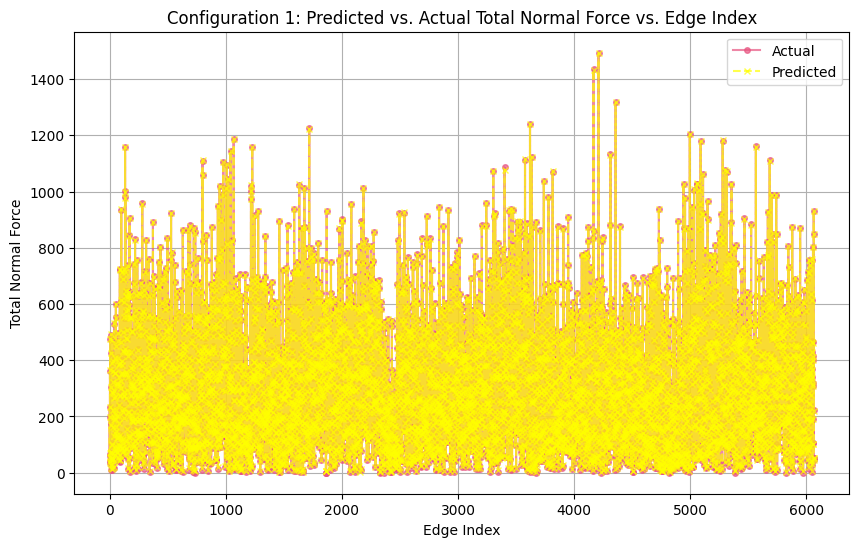

2025-05-12 20:32:03,561 - INFO - Saved plot for conf2 at C:\Users\UIET\Desktop\Ananya\IIT\Sem 6\BTP\post midsem data\Data_processed2\conf2_pred_actual_vs_edge_index.png


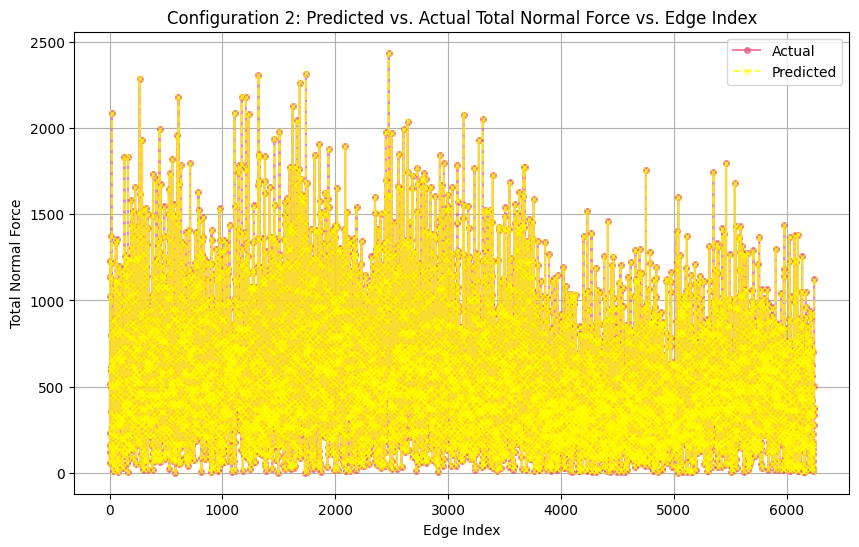

2025-05-12 20:32:04,777 - INFO - Saved plot for conf3 at C:\Users\UIET\Desktop\Ananya\IIT\Sem 6\BTP\post midsem data\Data_processed2\conf3_pred_actual_vs_edge_index.png


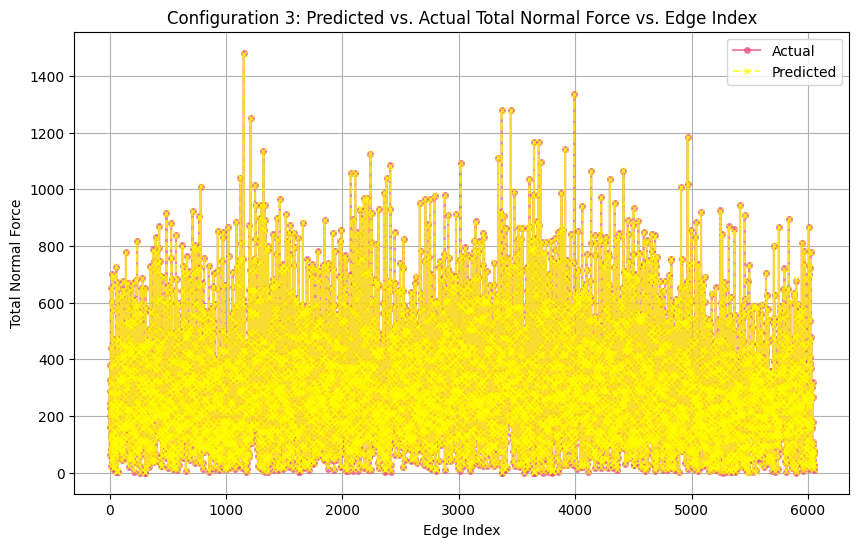

2025-05-12 20:32:05,811 - INFO - Saved plot for conf4 at C:\Users\UIET\Desktop\Ananya\IIT\Sem 6\BTP\post midsem data\Data_processed2\conf4_pred_actual_vs_edge_index.png


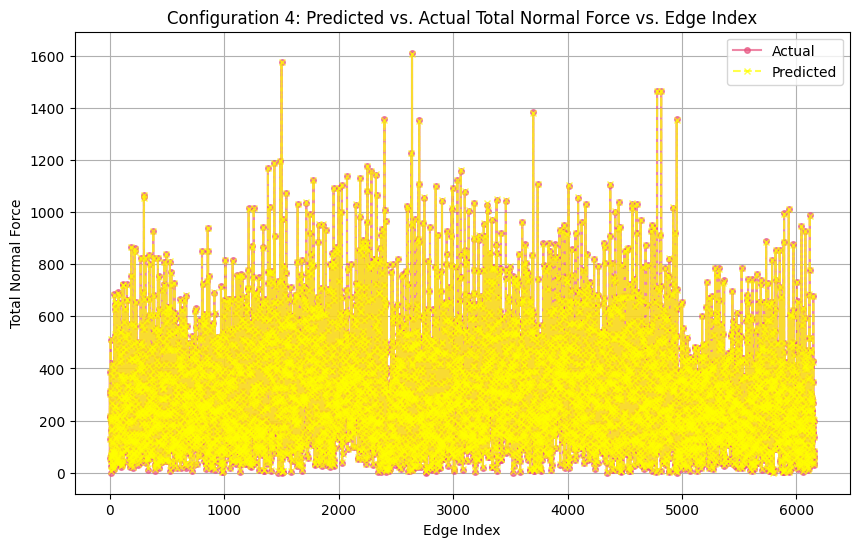

2025-05-12 20:32:06,921 - INFO - Saved plot for conf5 at C:\Users\UIET\Desktop\Ananya\IIT\Sem 6\BTP\post midsem data\Data_processed2\conf5_pred_actual_vs_edge_index.png


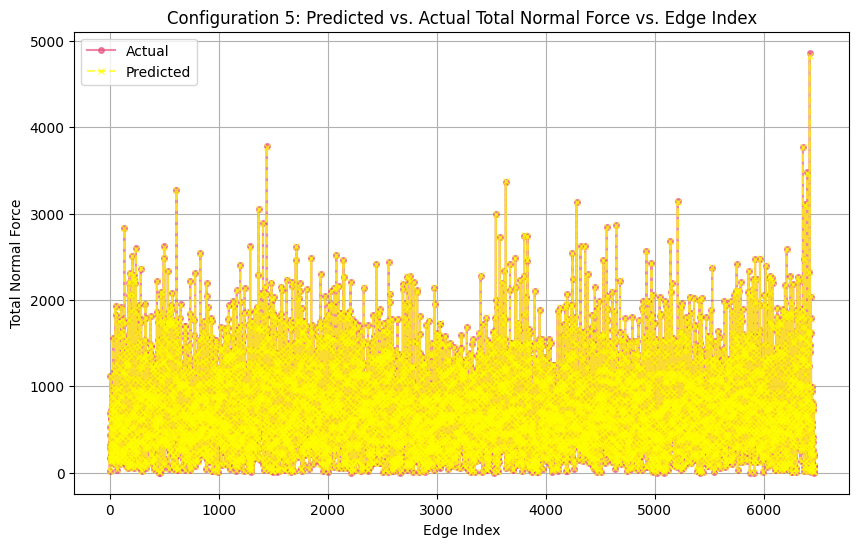

2025-05-12 20:32:07,977 - INFO - Saved plot for conf6 at C:\Users\UIET\Desktop\Ananya\IIT\Sem 6\BTP\post midsem data\Data_processed2\conf6_pred_actual_vs_edge_index.png


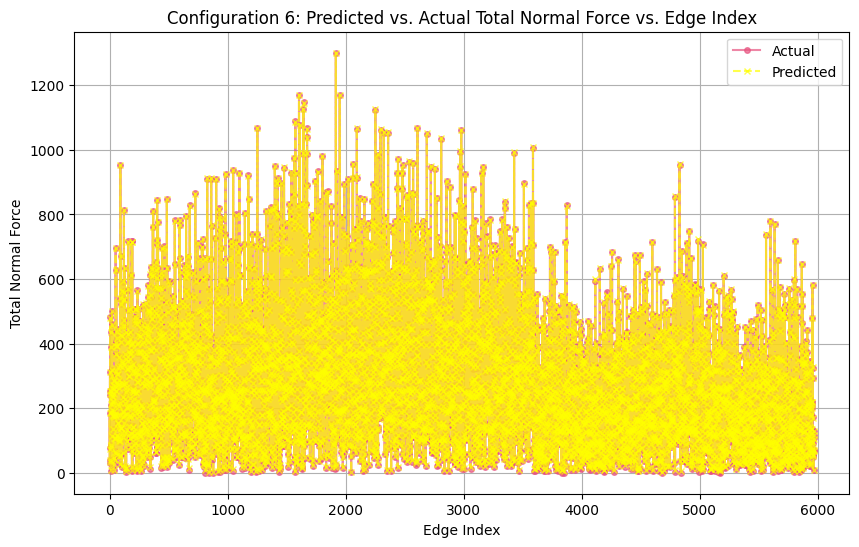

2025-05-12 20:32:09,131 - INFO - Saved plot for conf7 at C:\Users\UIET\Desktop\Ananya\IIT\Sem 6\BTP\post midsem data\Data_processed2\conf7_pred_actual_vs_edge_index.png


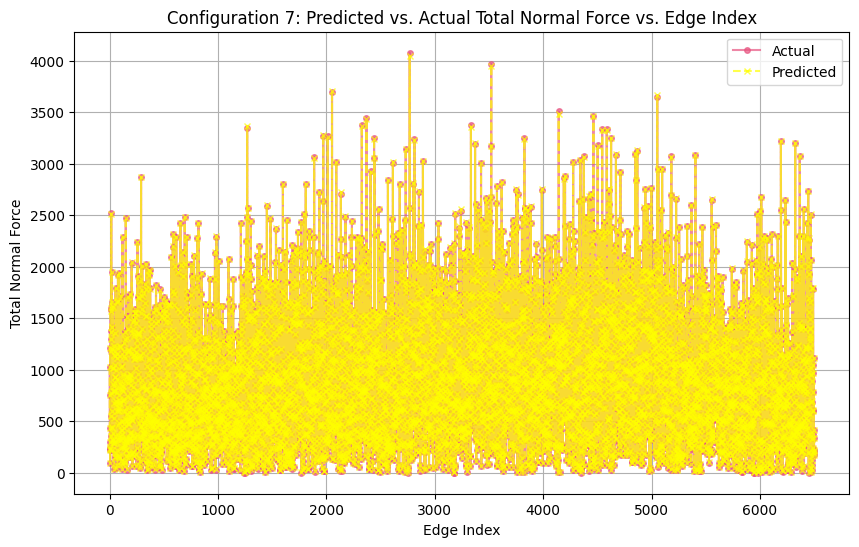

2025-05-12 20:32:10,345 - INFO - Saved plot for conf8 at C:\Users\UIET\Desktop\Ananya\IIT\Sem 6\BTP\post midsem data\Data_processed2\conf8_pred_actual_vs_edge_index.png


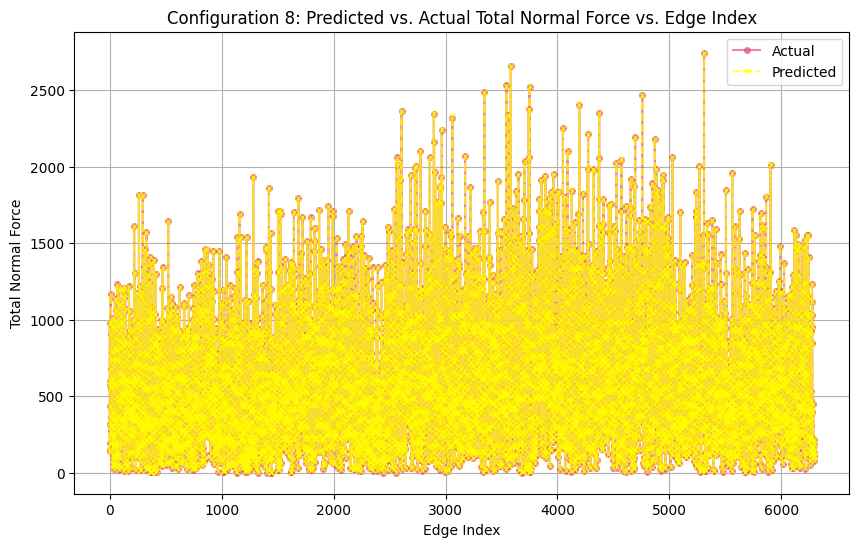

2025-05-12 20:32:11,533 - INFO - Saved plot for conf9 at C:\Users\UIET\Desktop\Ananya\IIT\Sem 6\BTP\post midsem data\Data_processed2\conf9_pred_actual_vs_edge_index.png


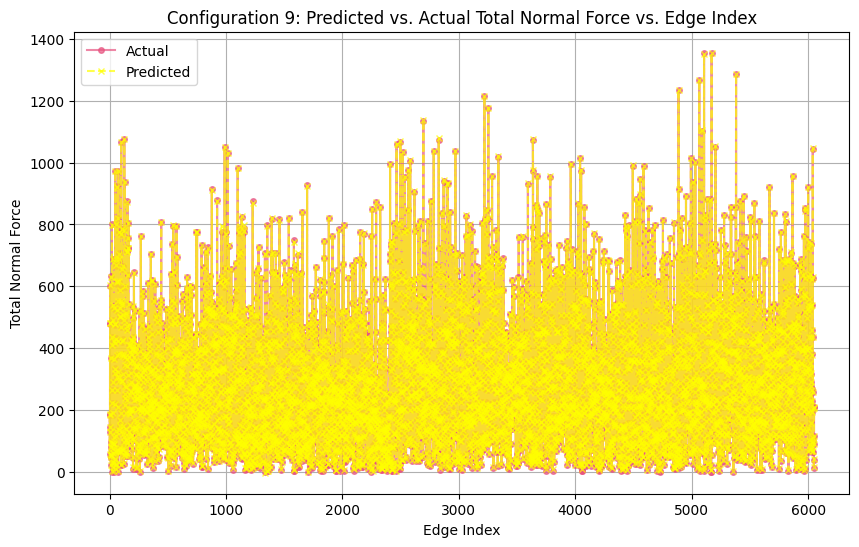

2025-05-12 20:32:12,798 - INFO - Saved plot for conf10 at C:\Users\UIET\Desktop\Ananya\IIT\Sem 6\BTP\post midsem data\Data_processed2\conf10_pred_actual_vs_edge_index.png


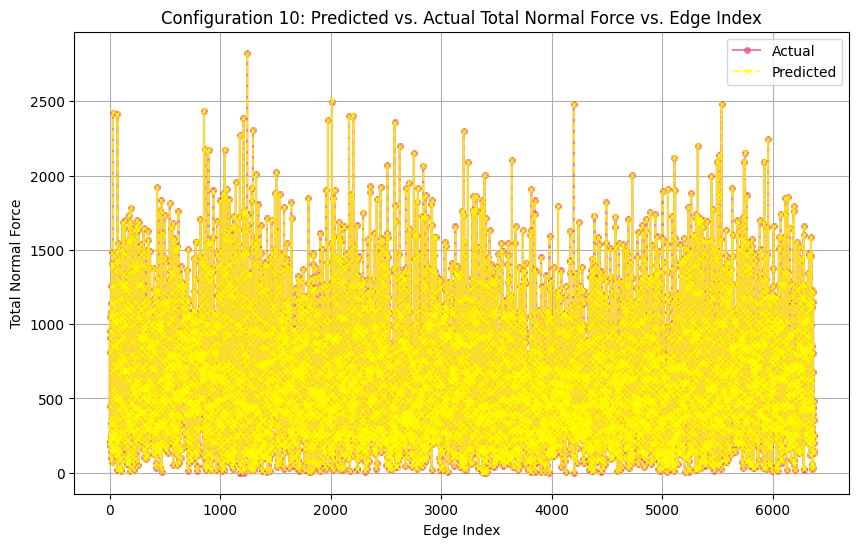

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
import logging
from torch_geometric.loader import DataLoader

# Ensure logging is set up (from Cell 1)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def plot_pred_actual_vs_edge_index(dataset, model, processed_data_path, device, target_scaler):
    """
    Generate line plots of predicted and actual total_normal_force vs. edge index for each configuration.
    
    Args:
        dataset: GranularDataset containing all configurations.
        model: Trained GNNModel.
        processed_data_path: Directory to save plots.
        device: Device (cuda or cpu) for model evaluation.
        target_scaler: StandardScaler for denormalizing predictions and targets.
    """
    model.eval()
    loader = DataLoader(dataset[:], batch_size=1, shuffle=False)  # Load all configurations
    
    for i, data in enumerate(loader, 1):  # Configurations are 1-indexed (conf1 to conf10)
        try:
            data = data.to(device)
            with torch.no_grad():
                preds = model(data)
            
            # Denormalize predictions and targets
            preds_denorm = target_scaler.inverse_transform(preds.cpu().numpy().reshape(-1, 1)).ravel()
            targets_denorm = target_scaler.inverse_transform(data.y.cpu().numpy().reshape(-1, 1)).ravel()
            
            # Edge indices (0 to N-1, where N is number of edges)
            edge_indices = np.arange(len(preds_denorm))
            
            # Create line plot
            plt.figure(figsize=(10, 6))
            plt.plot(edge_indices, targets_denorm, label='Actual', color='#E75480', linestyle='-', marker='o', markersize=4, alpha=0.7)  
            plt.plot(edge_indices, preds_denorm, label='Predicted', color='#FFFF00', linestyle='--', marker='x', markersize=4, alpha=0.7)  
            plt.xlabel('Edge Index')
            plt.ylabel('Total Normal Force')
            plt.title(f'Configuration {i}: Predicted vs. Actual Total Normal Force vs. Edge Index')
            plt.legend()
            plt.grid(True)
            
            # Save plot
            plot_path = os.path.join(processed_data_path, f'conf{i}_pred_actual_vs_edge_index.png')
            plt.savefig(plot_path)
            logging.info(f"Saved plot for conf{i} at {plot_path}")
            plt.show()
            plt.close()
            
        except Exception as e:
            logging.error(f"Error plotting for conf{i}: {e}")
            raise

# Run the plotting function
try:
    plot_pred_actual_vs_edge_index(dataset, model, processed_data_path, device, dataset.target_scaler)
except Exception as e:
    logging.error(f"Error in per-configuration plotting: {e}")
    raise